In [17]:
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [36]:
# problem = "_ChainPendulumn3mrlr.np"#"Gyroscope.np"
# files={(fname.split('_')[2]):fname for fname in glob.glob('rollout_errs_*'+problem)}
# # files.update({(fname.split('_')[2],3.1):fname for fname in glob.glob('rollout_errs_*'+problem)})
# # files.update({(fname.split('_')[2],3.1):fname for fname in glob.glob('rollout_errs_*'+problem)})

In [48]:
problem = ".np"#"Gyroscope.np"
files={(fname.split('_')[0]):fname for fname in glob.glob('*_pert_marc.np')}
# files.update({(fname.split('_')[2],3.1):fname for fname in glob.glob('rollout_errs_*'+problem)})
# files.update({(fname.split('_')[2],3.1):fname for fname in glob.glob('rollout_errs_*'+problem)})

In [49]:
files

{'NN': 'NN_pert_marc.np',
 'CHNN': 'CHNN_pert_marc.np',
 'HNN': 'HNN_pert_marc.np'}

In [50]:
import pandas as pd
import seaborn as sns
from biases.systems.rigid_body import rigid_Phi
from biases.systems.chain_pendulum import ChainPendulum

In [51]:
#rel_errs.shape

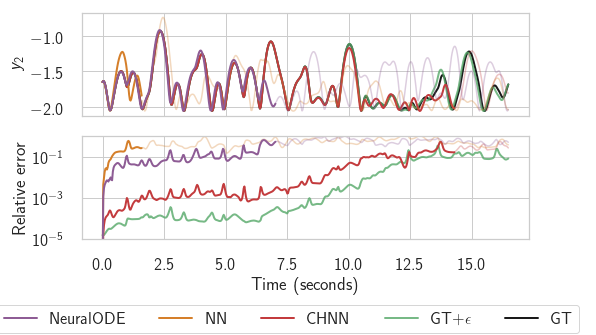

In [53]:
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)
body = ChainPendulum(3)
T =  body.dt * torch.arange(10*body.integration_time//body.dt)#.to(zt.device, zt.dtype)
small_T = T.cpu().data.numpy()[:100]
end_T = T.cpu().data.numpy()[:550]
end_idx = len(end_T)
data = []

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
colors = sns.color_palette("Set1", n_colors=5, desat=.67)
mapping = {'CHNN':0,'HNN':3,'NN':4}
fade_times = {'NN':4,'HNN':7,'CHNN':16.1}
fade_idx = {k:int(len(T)*v/(10*body.integration_time)) for k,v in fade_times.items()}
fig, ax = plt.subplots(nrows=2,ncols=1,sharex='col',sharey='row',figsize=(8,5))

ax[0].plot(end_T,zt_gt[idx,:end_idx,0,1,1].data.numpy(),label='GT',color='k',alpha=1,lw=2)
ax[0].plot(end_T,zt_pert[idx,:end_idx,0,1,1].cpu().data.numpy(),label=r'GT$+\epsilon$',color='g',alpha=.8,lw=2)
ax[1].plot(end_T,pert_rel_errs[idx,:end_idx].cpu().data.numpy(),label=r'GT$+\epsilon$',color='g',alpha=.8,lw=2)
idx = 2
for fname in sorted(files,key=lambda x:x[1]):
    rel_errs,pert_rel_errs,zt,zt_pert = pickle.load(open(files[fname],'rb'))
    #fid = fade_idx[fname]
    fid = min(np.argmax(rel_errs[idx].cpu().data.numpy()>.5)+20 if np.any(rel_errs[idx].cpu().data.numpy()>.5) else end_idx,end_idx)
    ax[0].plot(end_T[:fid],zt[idx,:fid,0,1,1].cpu().data.numpy(),label=fname,color=colors[mapping[fname]],lw=2)
    ax[1].plot(end_T[:fid],rel_errs[idx,:fid].cpu().data.numpy(),label=fname,color=colors[mapping[fname]],lw=2)
    ax[0].plot(end_T[fid:],zt[idx,fid:end_idx,0,1,1].cpu().data.numpy(),color=colors[mapping[fname]],alpha=.3)
    ax[1].plot(end_T[fid:],rel_errs[idx,fid:end_idx].cpu().data.numpy(),color=colors[mapping[fname]],alpha=.3)
    #avg_rel_err_pred = np.exp(np.mean(np.log(rel_errs.cpu().data.numpy()),axis=0))
#zero_rel_err = ((zt_gt[idx,:1]-zt_gt[idx,:])**2).sum(-1).sum(-1).sum(-1)/((zt_gt[idx,:1]+zt_gt[idx,:])**2).sum(-1).sum(-1).sum(-1)
#ax[1].plot(end_T,zero_rel_err[:end_idx].cpu().data.sqrt().numpy(),label='zero',color='k',alpha=.5,lw=2)
#     if zt.shape[1]>100:
#         ax[0,1].plot(end_T,zt[idx,:500,0,1,1].cpu().data.numpy(),label=fname)
        #ax[1,1].plot(end_T,rel_errs[idx,:500].cpu().data.numpy(),label=fname)
    #print(zt.shape)
#     zt_bt = zt.reshape(-1,*zt.shape[2:])
#     violation = rigid_Phi(body.body_graph,zt_bt[:,0],zt_bt[:,1]).abs().reshape(*zt.shape[:2],-1).mean(-1).log().cpu().data.numpy()
#     geometric_mean_violation = np.exp(np.mean(violation,axis=0))
#     # turn into list of series from batch of series   
#     data += [(fname[0],fname[1], batch, avg_rel_err_pred[batch],geometric_mean_violation[batch]) for batch in range(len(avg_rel_err_pred))]
# columns = ['Network', 'Removed Constraints', "Batch","Geometric Mean","Constraint Violation"]
#df = pd.DataFrame(data,columns=columns)
#zt_gt = body.integrate(zt[:,0].cpu(),T.cpu())

#ax[0,1].plot(end_T,zt_gt[idx,:500,0,1,1].cpu().data.numpy(),label='gt')
ax[1].set_yscale('log')
ax[1].set_ylim((1e-5,1))
ax[1].set_ylabel('Relative error')
ax[0].set_ylabel(r'$y_{2}$')
ax[1].set_xlabel("Time (seconds)")
handles, labels = ax[0].get_legend_handles_labels()
labels[-1] = 'NeuralODE'
fig.subplots_adjust(bottom=0.25)
#fig.legend(handles=handles[::-1], labels=labels[::-1],loc="best")
fig.legend(handles=handles[::-1], labels=labels[::-1], bbox_to_anchor=(0., 0., 1, 0.1), loc=8, ncol=len(labels), borderaxespad=0.1)
#fig.savefig("perturbation.pdf", bbox_inches="tight")

In [93]:
sns.color_palette("Set1", n_colors=5, desat=.67)

[(0.7634117647058823, 0.2326666666666667, 0.2379215686274509),
 (0.299156862745098, 0.4857058823529412, 0.6380980392156863),
 (0.36343137254901964, 0.6209215686274511, 0.35554901960784313),
 (0.5553137254901963, 0.36088235294117643, 0.5842156862745098),
 (0.835, 0.4986862745098039, 0.16500000000000004)]

In [60]:
zt_gt.shape

torch.Size([100, 100, 2, 3, 2])

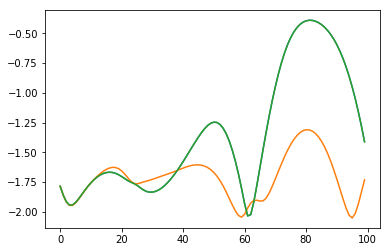

In [35]:

plt.plot(zt[0,:,0,1,1].cpu().data.numpy())
plt.plot(zt_pert[0,:,0,1,1].cpu().data.numpy())

In [ ]:
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [ ]:
problem = "_ChainPendulumn3mrlr.np"#"Gyroscope.np"
files={(fname.split('_')[2]):fname for fname in glob.glob('rollout_errs_*'+problem)}
# files.update({(fname.split('_')[2],3.1):fname for fname in glob.glob('rollout_errs_*'+problem)})
# files.update({(fname.split('_')[2],3.1):fname for fname in glob.glob('rollout_errs_*'+problem)})
import pandas as pd
import seaborn as sns
from biases.systems.rigid_body import rigid_Phi
from biases.systems.gyroscope import gyro